
# LAB-01 — Predicción de *default* con Random Forest (Notebook)

Este cuaderno implementa, **paso a paso**, lo solicitado en `homework.py` para el dataset de *default payment next month*.
Cada sección está rotulada con **Paso N** tal como en el enunciado, e incluye código y explicación breve.


## Imports

In [2]:

import os
import gzip
import json
import pickle
import zipfile
from glob import glob
from pathlib import Path

import pandas as pd  # type: ignore

from sklearn.compose import ColumnTransformer  # type: ignore
from sklearn.ensemble import RandomForestClassifier  # type: ignore
from sklearn.metrics import (  # type: ignore
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV  # type: ignore
from sklearn.pipeline import Pipeline  # type: ignore
from sklearn.preprocessing import OneHotEncoder  # type: ignore

# Directorios de trabajo esperados por los tests
FILES_DIR = Path("../files")
INPUT_DIR = FILES_DIR / "input"
MODELS_DIR = FILES_DIR / "models"
OUTPUT_DIR = FILES_DIR / "output"

for d in [FILES_DIR, INPUT_DIR, MODELS_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)



## Carga de datos desde `files/input/` 

Leeremos los archivos `.zip` que contienen los CSV de entrenamiento y prueba.


In [3]:

def leer_zip_a_dfs(directorio: str) -> list[pd.DataFrame]:
    """Lee todos los ZIP en `directorio` y retorna una lista de DataFrames."""
    dataframes = []
    for zip_path in glob(os.path.join(directorio, "*")):
        with zipfile.ZipFile(zip_path, "r") as zf:
            for miembro in zf.namelist():
                with zf.open(miembro) as fh:
                    df = pd.read_csv(fh, sep=",", index_col=0)
                    # Guardamos la pista del origen para poder identificar train/test
                    df.attrs["__source_zip__"] = zip_path
                    df.attrs["__source_csv__"] = miembro
                    dataframes.append(df)
    return dataframes

dfs = leer_zip_a_dfs(str(INPUT_DIR))

print("Usando archivos:")
for d in dfs:
    print("  ", d.attrs.get("__source_zip__"), "::", d.attrs.get("__source_csv__"))
print([df.shape for df in dfs])


Usando archivos:
   ..\files\input\test_data.csv.zip :: test_default_of_credit_card_clients.csv
   ..\files\input\train_data.csv.zip :: train_default_of_credit_card_clients.csv
[(9000, 24), (21000, 24)]



## Paso 1 — Limpieza de datasets

- Renombrar `"default payment next month"` a `"default"`  
- Remover columna `ID` (si existe)  
- Eliminar registros con *N/A*  
- Para `EDUCATION`: valores `> 4` se agrupan como `4` (*others*).


In [4]:

def depurar(df: pd.DataFrame) -> pd.DataFrame:
    tmp = df.copy()
    # Renombrar la variable objetivo
    if "default payment next month" in tmp.columns:
        tmp = tmp.rename(columns={"default payment next month": "default"})
    # Remover ID 
    if "ID" in tmp.columns:
        tmp = tmp.drop(columns=["ID"])    
    # Filtrar valores no definidos en MARRIAGE / EDUCATION si vienen codificados como 0
    if "MARRIAGE" in tmp.columns:
        tmp = tmp.loc[tmp["MARRIAGE"] != 0]
    if "EDUCATION" in tmp.columns:
        tmp = tmp.loc[tmp["EDUCATION"] != 0]
        tmp["EDUCATION"] = tmp["EDUCATION"].apply(lambda v: 4 if v >= 4 else v)
    # Quitar filas con NA
    return tmp.dropna()

# Intentamos identificar cuál es train y cuál es test usando el nombre del ZIP/CSV
train_df, test_df = None, None
for d in dfs:
    src = (str(d.attrs.get("__source_zip__")) + " " + str(d.attrs.get("__source_csv__"))).lower()
    if "train" in src:
        train_df = depurar(d)
    elif "test" in src:
        test_df = depurar(d)

# Si no se detectó por nombre, conservamos el orden [test, train] como en el script original
if train_df is None or test_df is None:
    df_list = [depurar(d) for d in dfs]
    if len(df_list) >= 2:
        test_df, train_df = df_list[0], df_list[1]
    else:
        raise RuntimeError("No se encontraron suficientes archivos de entrada en files/input/")

print("Shapes depurados:", train_df.shape, test_df.shape)


Shapes depurados: (20953, 24) (8979, 24)



## Paso 2 — División en $X$ e $y$ (entrenamiento y prueba)


In [5]:

def separar_xy(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(columns=["default"])
    y = df["default"]
    return X, y

X_train, y_train = separar_xy(train_df)
X_test, y_test = separar_xy(test_df)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((20953, 23), (8979, 23), (20953,), (8979,))


## Paso 3 — Pipeline (One-Hot Encoding + Random Forest)

Creamos un `ColumnTransformer` que aplica **one-hot-encoding** a las categóricas y deja el resto **passthrough**.  
Luego un `Pipeline` que agrega un **RandomForestClassifier**.


In [6]:

def ensamblar_busqueda() -> GridSearchCV:
    cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
    ohe = OneHotEncoder(handle_unknown="ignore")
    ct = ColumnTransformer(
        transformers=[("cat", ohe, cat_cols)],
        remainder="passthrough",
    )

    clf = RandomForestClassifier(random_state=42)
    pipe = Pipeline(steps=[("prep", ct), ("rf", clf)])

    grid_params = {
        "rf__n_estimators": [100, 200, 500],
        "rf__max_depth": [None, 5, 10],
        "rf__min_samples_split": [2, 5],
        "rf__min_samples_leaf": [1, 2],
    }

    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid_params,
        cv=10,
        scoring="balanced_accuracy",
        n_jobs=-1,
        refit=True,
        verbose=2,
    )
    return gs

buscador = ensamblar_busqueda()
buscador


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [None, 5, ...], 'rf__min_samples_leaf': [1, 2], 'rf__min_samples_split': [2, 5], 'rf__n_estimators': [100, 200, ...]}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,10
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"



## Paso 4 — Optimización por validación cruzada (10 *folds*) con *balanced accuracy*


In [7]:

_ = buscador.fit(X_train, y_train)
print("Mejores hiperparámetros:", buscador.best_params_)
print("Mejor balanced_accuracy (CV):", buscador.best_score_)


Fitting 10 folds for each of 36 candidates, totalling 360 fits
Mejores hiperparámetros: {'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 500}
Mejor balanced_accuracy (CV): 0.6599345651274584



## Paso 5 — Guardar el modelo comprimido (`gzip`) en `files/models/model.pkl.gz`


In [8]:

def reiniciar_directorio(ruta: str) -> None:
    if os.path.exists(ruta):
        for f in glob(os.path.join(ruta, "*")):
            try:
                os.remove(f)
            except IsADirectoryError:
                pass
        try:
            os.rmdir(ruta)
        except OSError:
            pass
    os.makedirs(ruta, exist_ok=True)

def guardar_modelo_gz(ruta_salida: str, objeto) -> None:
    reiniciar_directorio(os.path.dirname(ruta_salida))
    with gzip.open(ruta_salida, "wb") as fh:
        pickle.dump(objeto, fh)

model_path = str(MODELS_DIR / "model.pkl.gz")
guardar_modelo_gz(model_path, buscador)
model_path


'..\\files\\models\\model.pkl.gz'


## Paso 6 — Métricas (train / test): precision, balanced_accuracy, recall, f1


In [9]:

def empaquetar_metricas(etiqueta: str, y_true, y_pred) -> dict:
    return {
        "type": "metrics",
        "dataset": etiqueta,
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1_score": float(f1_score(y_true, y_pred, zero_division=0)),
    }

yhat_train = buscador.predict(X_train)
yhat_test = buscador.predict(X_test)

m_train = empaquetar_metricas("train", y_train, yhat_train)
m_test = empaquetar_metricas("test", y_test, yhat_test)

m_train, m_test


({'type': 'metrics',
  'dataset': 'train',
  'precision': 0.996859144720947,
  'balanced_accuracy': 0.9362132143411415,
  'recall': 0.8732275132275132,
  'f1_score': 0.930956678700361},
 {'type': 'metrics',
  'dataset': 'test',
  'precision': 0.6597938144329897,
  'balanced_accuracy': 0.6734752659604849,
  'recall': 0.40293809024134314,
  'f1_score': 0.5003257328990228})


## Paso 7 — Matrices de confusión (train / test) y escritura de `files/output/metrics.json`


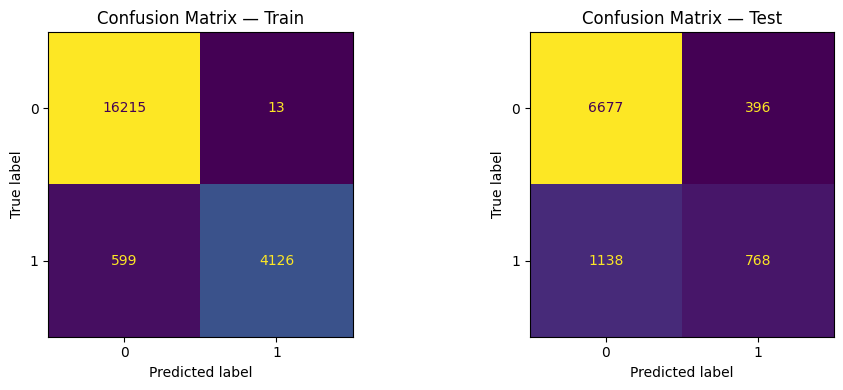

WindowsPath('../files/output/metrics.json')

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def empaquetar_matriz_conf(etiqueta: str, y_true, y_pred) -> dict:
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    return {
        "type": "cm_matrix",
        "dataset": etiqueta,
        "true_0": {"predicted_0": int(cm[0][0]), "predicted_1": int(cm[0][1])},
        "true_1": {"predicted_0": int(cm[1][0]), "predicted_1": int(cm[1][1])},
    }

cm_train = empaquetar_matriz_conf("train", y_train, yhat_train)
cm_test  = empaquetar_matriz_conf("test",  y_test,  yhat_test)

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
metrics_path = OUTPUT_DIR / "metrics.json"
with open(metrics_path, "w", encoding="utf-8") as fh:
    fh.write(json.dumps(m_train) + "\n")
    fh.write(json.dumps(m_test) + "\n")
    fh.write(json.dumps(cm_train) + "\n")
    fh.write(json.dumps(cm_test) + "\n")

# --- Ploteo de matrices de confusión (train / test) ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4), squeeze=False)

cm_tr = confusion_matrix(y_train, yhat_train, labels=[0, 1])
cm_te = confusion_matrix(y_test,  yhat_test,  labels=[0, 1])

disp_tr = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=[0, 1])
disp_te = ConfusionMatrixDisplay(confusion_matrix=cm_te, display_labels=[0, 1])

disp_tr.plot(ax=axes[0][0], values_format='d', colorbar=False)
axes[0][0].set_title("Confusion Matrix — Train")

disp_te.plot(ax=axes[0][1], values_format='d', colorbar=False)
axes[0][1].set_title("Confusion Matrix — Test")

plt.tight_layout()
plt.show()

metrics_path



## Resultado
- Modelo guardado en: `files/models/model.pkl.gz`  
- Métricas (y matrices de confusión) guardadas en: `files/output/metrics.json`


In [11]:

from pprint import pprint
print("Contenido de files/output/metrics.json:\n")
with open(OUTPUT_DIR / "metrics.json", "r", encoding="utf-8") as fh:
    for line in fh:
        pprint(json.loads(line))


Contenido de files/output/metrics.json:

{'balanced_accuracy': 0.9362132143411415,
 'dataset': 'train',
 'f1_score': 0.930956678700361,
 'precision': 0.996859144720947,
 'recall': 0.8732275132275132,
 'type': 'metrics'}
{'balanced_accuracy': 0.6734752659604849,
 'dataset': 'test',
 'f1_score': 0.5003257328990228,
 'precision': 0.6597938144329897,
 'recall': 0.40293809024134314,
 'type': 'metrics'}
{'dataset': 'train',
 'true_0': {'predicted_0': 16215, 'predicted_1': 13},
 'true_1': {'predicted_0': 599, 'predicted_1': 4126},
 'type': 'cm_matrix'}
{'dataset': 'test',
 'true_0': {'predicted_0': 6677, 'predicted_1': 396},
 'true_1': {'predicted_0': 1138, 'predicted_1': 768},
 'type': 'cm_matrix'}
